In [329]:
import ratio
import numpy as np
import matplotlib.pyplot as plt

# Load packages
import json
import matplotlib.pyplot as plt
import numpy as np
import openturns as ot
import pandas as pd
import scipy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from bokeh.io import output_notebook, push_notebook, show
from bokeh.plotting import figure
from bokeh.transform import linear_cmap

#from ggplot import *
from sklearn import cluster, mixture
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from fda import *

output_notebook()

Loading BokehJS ...

In [330]:
# Various paramaters
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.size'] = 15
plt.rcParams['lines.markersize'] = 4
plt.rcParams['axes.linewidth'] = 0.2
plt.rcParams['xtick.major.width'] = 0.2
plt.rcParams['ytick.major.width'] = 0.2

plt.rcParams['text.usetex'] = False
plt.rcParams['font.serif'] = "cm"

In [331]:
# Some functions
def plot_month(data, date):
    """Plot the data for one month."""
    df = data.loc[date]

    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(df)
    ax.set_xlim([0, len(df)-1])
    
    plt.title(' '.join(['Manufacturing month:', date]))
    plt.xlabel('Month since manufacturing')
    plt.ylabel('Cost by vehicle')
    plt.xticks(np.arange(0, len(df), 2))
    plt.grid()
    plt.show()

def plot_months(data,length=25,title="Warranty cost",color = False, show = True):
    """Plot the data for all the months."""
    df = data.T
     
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if not color :
        ax.plot(df)
    else:
        ax.plot(df,color=color,linewidth=2)
    ax.set_xlim([0, length])
    
    plt.title(title)
    plt.xlabel('Month since manufacturing')
    plt.xticks(np.arange(0, length, 2))
    plt.ylabel('Cost per vehicle')
    plt.grid()
    if(show):
        plt.show()
    return fig

def add_plot_months(data, fig):
    df = data.T
    
    ax = fig.add_subplot(111)
    ax.plot(df,color="blue",linewidth=2)
    ax.set_xlim([0, 25])
    
    plt.xlabel('Month since manufacturing')
    plt.xticks(np.arange(0, 25, 2))
    plt.ylabel('Cost per vehicle')
    plt.grid()
    plt.show()
    
def plot_coefs(data, number):
    """Plot the coefficient of a principal component through time."""
    df = data[number]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(month, df)
    
    plt.title(' '.join(['Plot of the scores of the', str(number), 'principal components']))
    plt.xlabel('Months')
    plt.xticks(rotation=45)
    plt.ylabel('Principal components scores')
    plt.grid()
    plt.show()

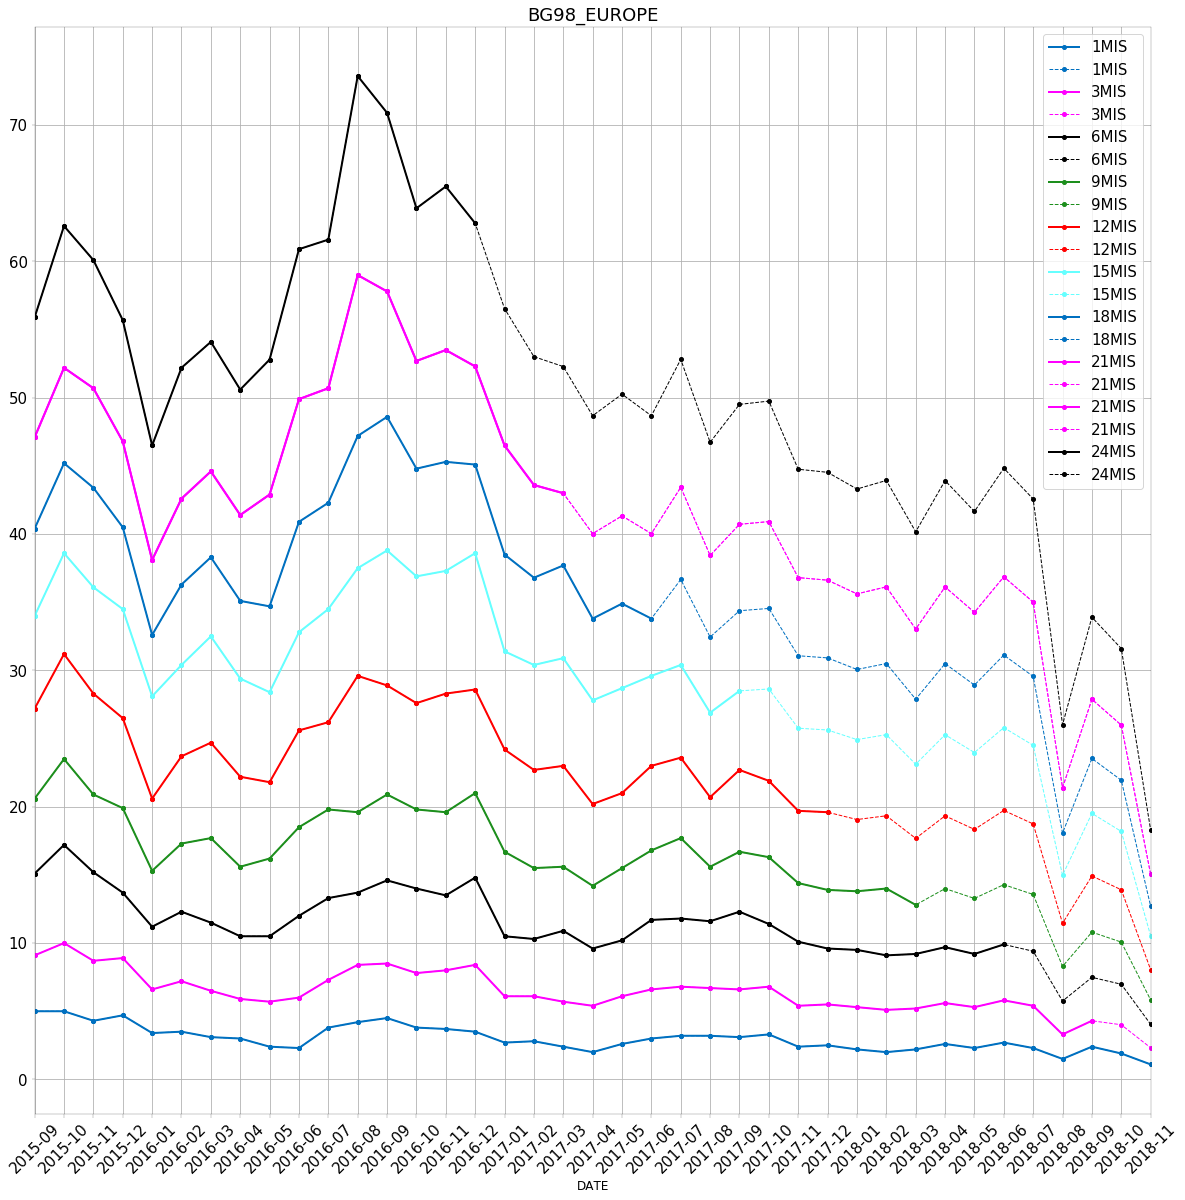

In [332]:
csvFilename = "BG98_EUROPE.csv"

r = ratio.ratioCore()

r.getData(csvFilename)
r.plotMis(["1MIS", "3MIS", "6MIS", "9MIS", "12MIS", "15MIS", "18MIS", "21MIS", "21MIS", "24MIS"])
r.calculateRatio(["21/6MIS", "21/3MIS"])

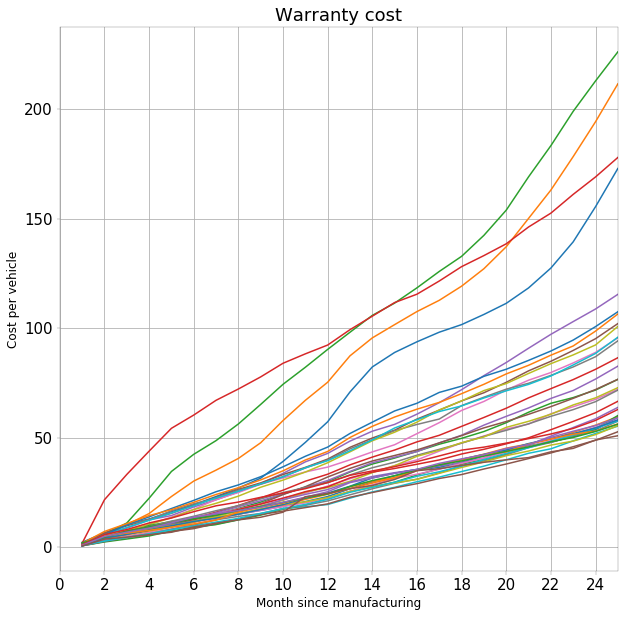

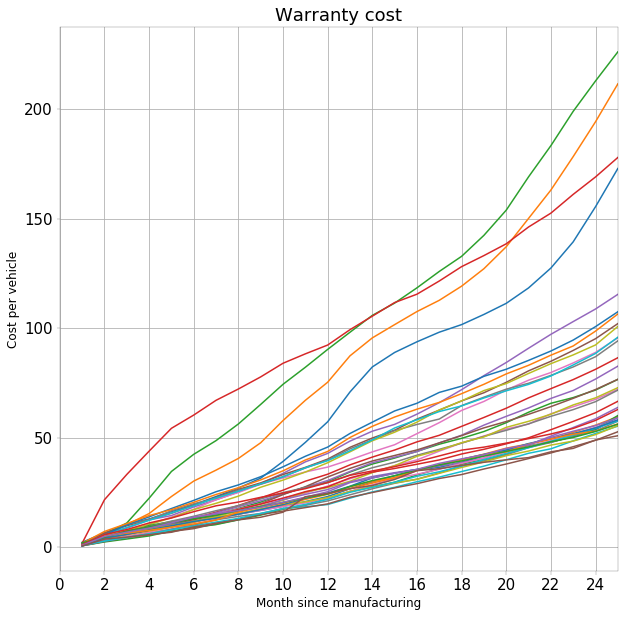

In [333]:
# Load the data
df = pd.read_csv('./B98.csv', header=None, index_col=0)
# Build the cumulative dataframe.
df_cum = df.cumsum(axis=1)
# Plot all the months (cumulative costs)
plot_months(df_cum)

In [345]:
data = r.data

mis = ["1MIS", "3MIS", "6MIS", "9MIS", "12MIS", "15MIS", "18MIS", "21MIS", "24MIS"]

cout=[]
columns=[]
for i in range(len(data)):
    month_cout=[]
    month_data = data.loc[i]

    for m in mis:   
        if(i==0):
            if(len(m)==4):
                month = int(m[0])
            elif(len(m)==5):
                month = int(m[0:2])
            columns.append(month)
        
        month_cout.append(month_data[m])
    cout.append(month_cout)

cout=np.array(cout)


df = pd.DataFrame(cout, index = data["DATE"],columns=columns)


#plot_months(df)


In [347]:
def fill_blank(df):
    #Ici on suppose qu'on a un dataFrame avec seulement 1,3,6,9 etc et on veut faire un truc linéaire 
    #pour compléter avec les mois [1,2,3,4,5....]
    data = df.values
    months = df.columns
    new_column =np.around((data[:,1] + data[:,0])/2,decimals = 1)

    
    data = np.concatenate((np.array([data[:,0], new_column]).T,data[:,1:]),axis=1)
    
    for i in [3,6,9,12,15,18,21]:
    
        new_column_1 = np.around((data[:,i] - data[:,i-1])/3 + data[:,i-1], decimals = 1)
        new_column_2 = np.around(2*(data[:,i] - data[:,i-1])/3 + data[:,i-1], decimals = 1)
        new_column = np.array([new_column_1, new_column_2]).T
        data = np.concatenate((data[:,:i],new_column,data[:,i:]),axis=1)

    df = pd.DataFrame(data, index = df.index,columns=np.arange(1,25))
    return df
    
df_fill = fill_blank(df)

          1    2     3     4     5     6     7     8     9     10  ...    15  \
DATE                                                               ...         
2015-09  5.0  7.0   9.1  11.1  13.1  15.1  16.9  18.8  20.6  22.8  ...  34.0   
2015-10  5.0  7.5  10.0  12.4  14.8  17.2  19.3  21.4  23.5  26.1  ...  38.6   
2015-11  4.3  6.5   8.7  10.9  13.0  15.2  17.1  19.0  20.9  23.4  ...  36.1   
2015-12  4.7  6.8   8.9  10.5  12.1  13.7  15.8  17.8  19.9  22.1  ...  34.5   
2016-01  3.4  5.0   6.6   8.1   9.7  11.2  12.6  13.9  15.3  17.1  ...  28.1   
2016-02  3.5  5.4   7.2   8.9  10.6  12.3  14.0  15.6  17.3  19.4  ...  30.4   
2016-03  3.1  4.8   6.5   8.2   9.8  11.5  13.6  15.6  17.7  20.0  ...  32.5   
2016-04  3.0  4.4   5.9   7.4   9.0  10.5  12.2  13.9  15.6  17.8  ...  29.4   
2016-05  2.4  4.0   5.7   7.3   8.9  10.5  12.4  14.3  16.2  18.1  ...  28.4   
2016-06  2.3  4.2   6.0   8.0  10.0  12.0  14.2  16.3  18.5  20.9  ...  32.8   
2016-07  3.8  5.6   7.3   9.3  11.3  13.

/home/jean-baptiste/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


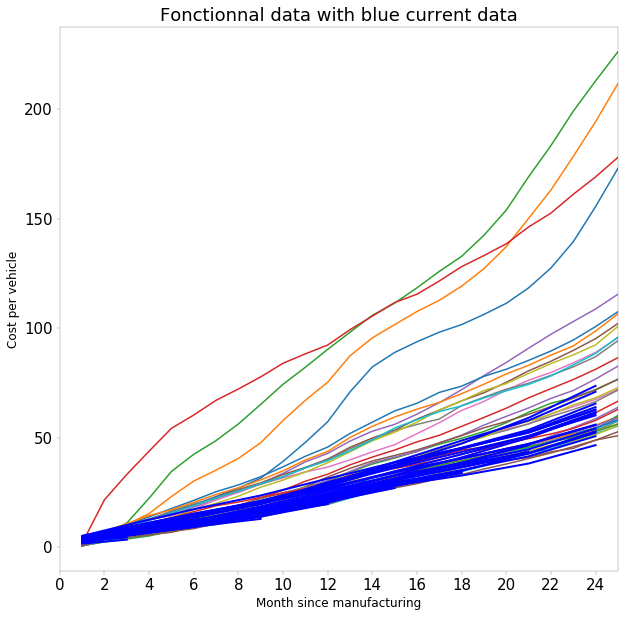

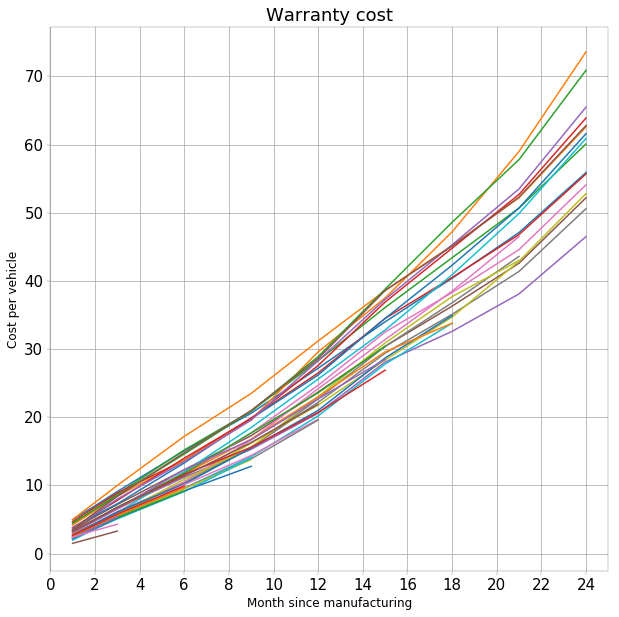

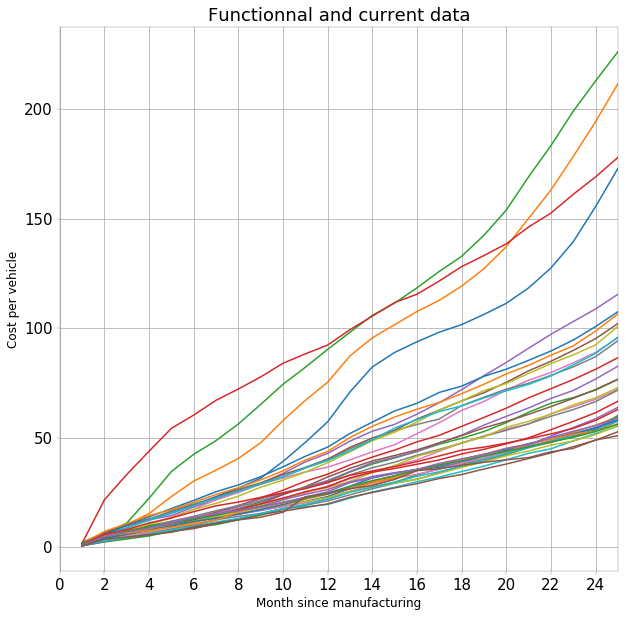

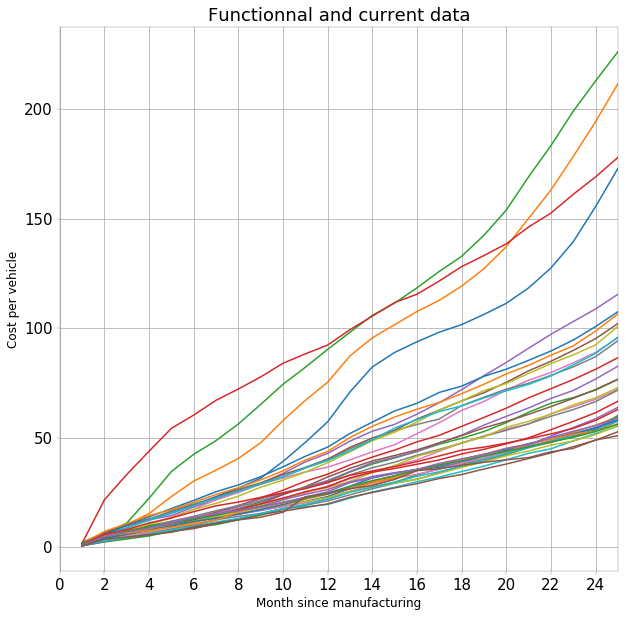

In [336]:
fig = plot_months(df_cum,title="Fonctionnal data with blue current data",show = False )
add_plot_months(df_fill, fig)
df_res = pd.concat([df_cum,df])

plot_months(df_fill)

plot_months(df_res,title = "Functionnal and current data")

## PCA

In [337]:
from sklearn.decomposition import PCA

def build_pca(x, show_porcent = True):
    # calculate the PCA (Eigenvectors & Eigenvalues of the covariance matrix)
    pcaA = PCA(n_components=3, copy=True, whiten=False)

    pcaA.fit(x)
    dpca = pd.DataFrame(pcaA.transform(x))
    dpca.index = x.index
    if(show_porcent):
        for i,pc in enumerate(pcaA.explained_variance_ratio_):
            print('{0}.\t{1:2.2f}%'.format(i+1,pc*100.0))
    return pcaA

In [338]:
def plot_pca(pcaA):
    fig = plt.figure(figsize=(16,10))
    plt.title('First {0} PCA components'.format(np.shape(np.transpose(pcaA.components_))[-1]))

    plt.plot(np.transpose(pcaA.components_), label=['1. PC', '2. PC'])
    plt.legend('upper right')

    plt.show()



## Reconstruction de la courbe

In [339]:
def plot_rebuild(pcaA):
    H = []
    S = []

    for j in range(len(pcaA.components_[0])):
        H.append(j)
        s = 0
        for i in range(len(pcaA.components_)):
            s += pcaA.components_[i][j] * pcaA.singular_values_[i]
        S.append(s)
    plt.plot(H,S)
    plt.xlabel('months')
    plt.ylabel('cumulate costs')
    plt.show()
    
def plot_variance(x):
    H = []
    S = []
    for i in range(1,25):
        pcaA = PCA(n_components=i, copy=True, whiten=False)
        pcaA.fit(x)
        dpca = pd.DataFrame(pcaA.transform(x))
        dpca.index = x.index
        L = np.cumsum(pcaA.explained_variance_ratio_)
        H.append(i)
        S.append(L[-1])
    plt.plot(H,S)
    plt.xlabel('nombre de composante:')
    plt.ylabel('% de variance expliqué')
    plt.show()

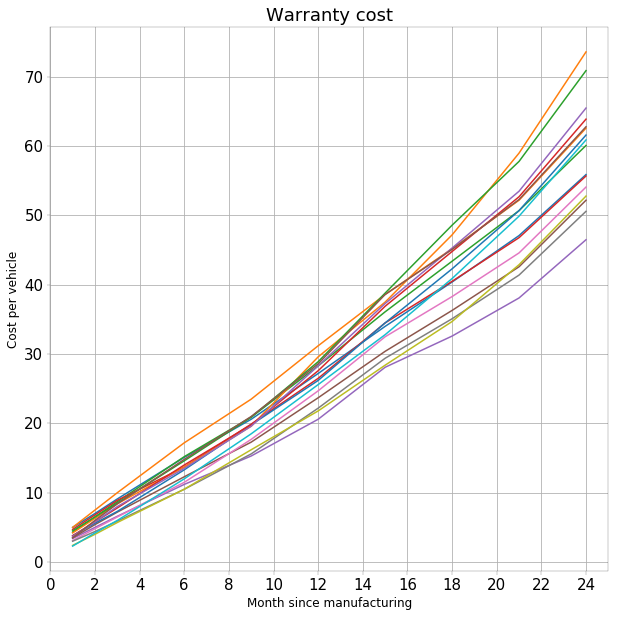

1.	93.20%
2.	5.95%
3.	0.47%


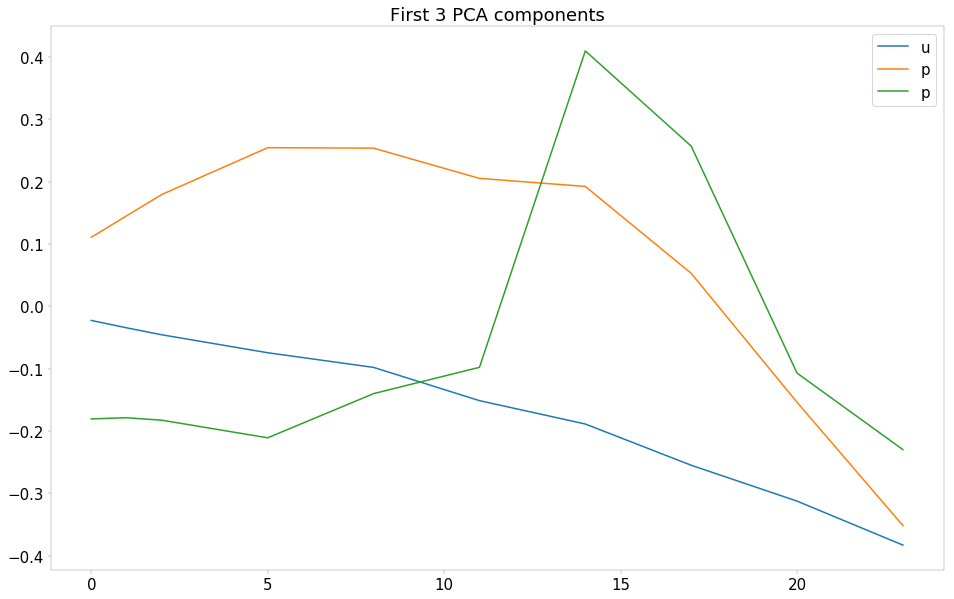

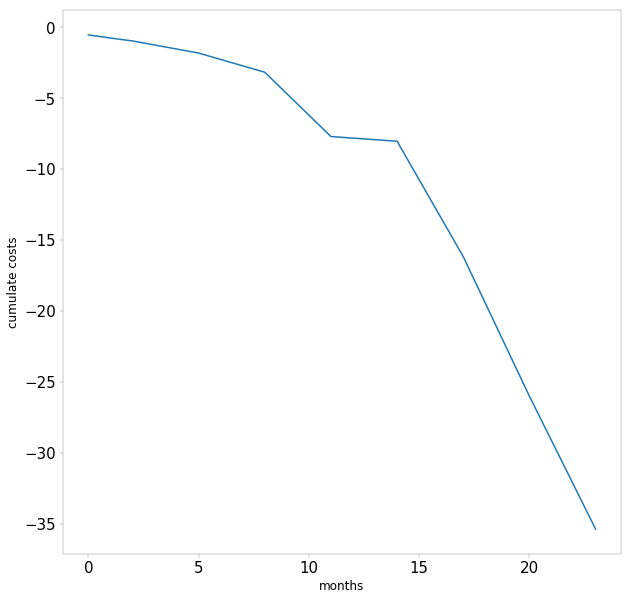

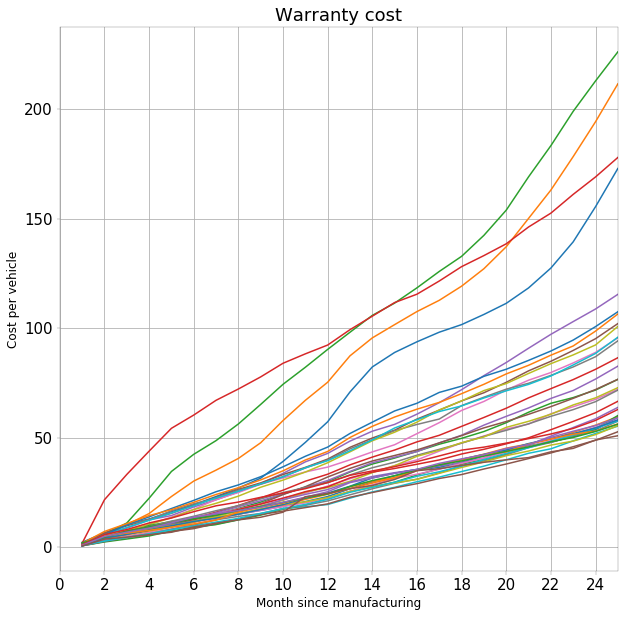

1.	98.03%
2.	1.68%
3.	0.17%


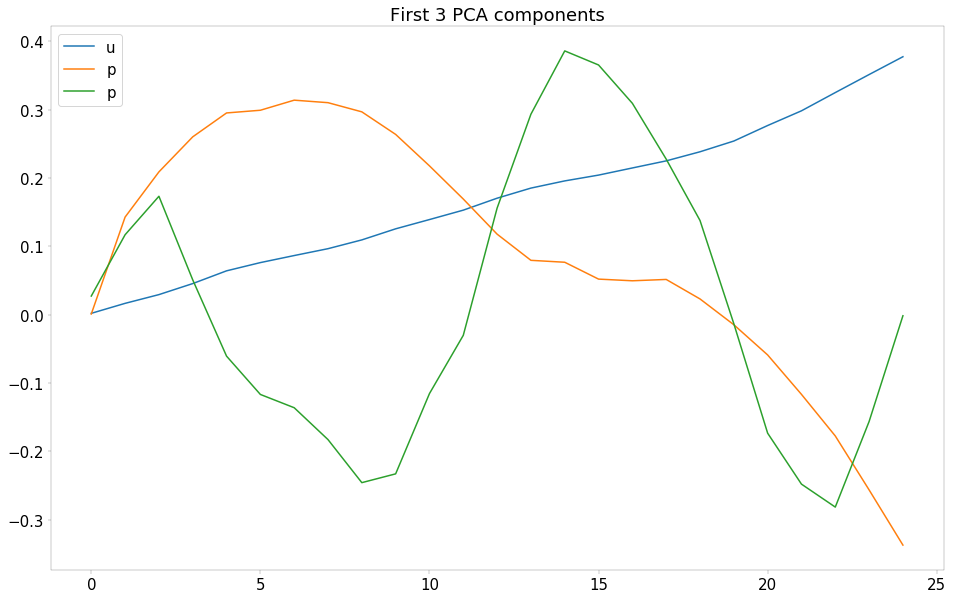

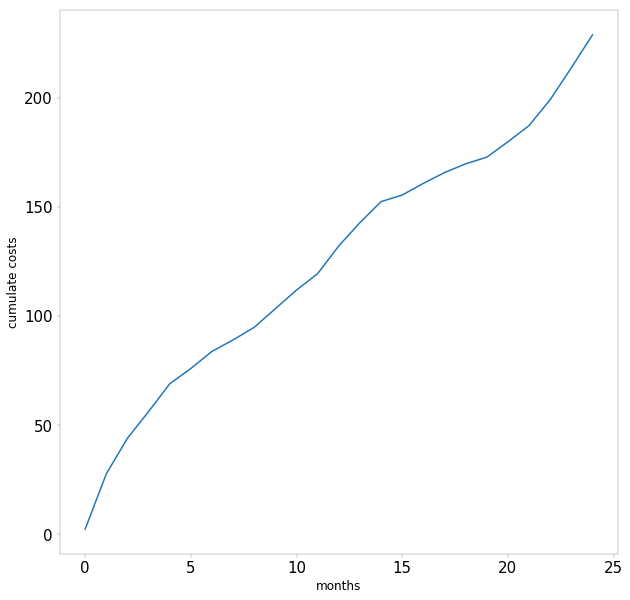

In [340]:


x=  df_fill.loc[:"2016-12"]


plot_months(x)

pcaA = build_pca(x)
plot_pca(pcaA)
plot_rebuild(pcaA)

x=df_cum

plot_months(x)

pcaA = build_pca(x)
plot_pca(pcaA)
plot_rebuild(pcaA)

## Résoudre le problème de minimisation 

La pca nous donne 3 fonctions que l'on note $e_1, e_2, e_3$ qui sont ici des vecteurs en dimension 24, on a des données sous forme d'un vecteur x de dimension k on doit trouver $\lambda_1, \lambda_2, \lambda_3$ qui minimisent $\sum_i^k \left( (\lambda_1 * e_1 + \lambda_2 * e_2 + \lambda_3 * e_3)[i] - x[i] \right)^2$

                1         2        3         4
0                                             
11/2015  0.757372  4.776622  6.71191  8.586443 

lambdas =  [99.10488465 14.1223893   6.5717575 ]


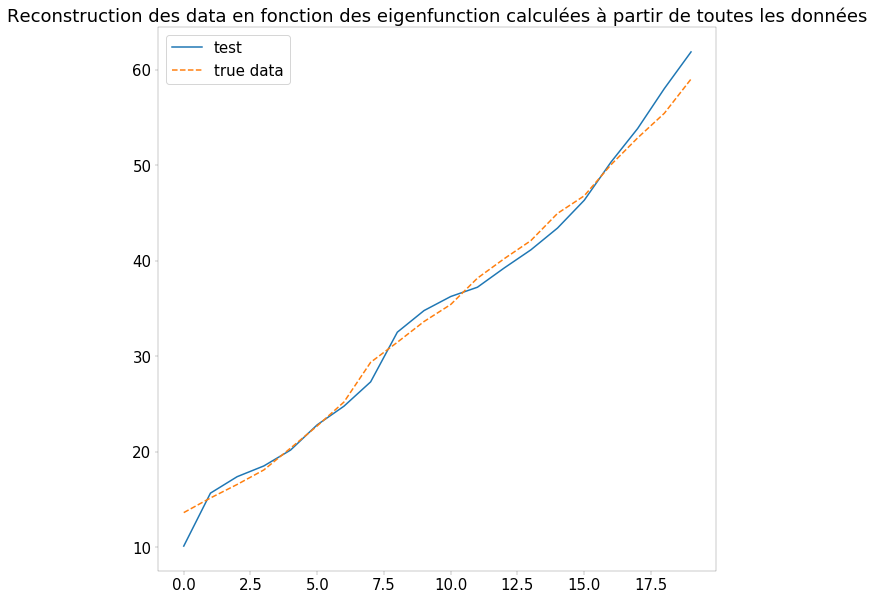

In [341]:
from scipy.optimize import minimize

k=4

x = df_cum
x = x[34:35].T[:k].T #les 4 premiers mois du 11/2015
print(x,"\n")
x = x.values[0]

##Faisons la pca sur les valeurs df_cum 

pca_ref = build_pca(df_cum, show_porcent = False)

#On peut ensuite définir la fonction à minimiser 

e=np.array(pca_ref.components_ )#eigenfunctions

def to_minimize(lambdas):
    temp = lambdas[0]*e[0][:len(x)] + lambdas[1]*e[1][:len(x)] + lambdas[2]*e[2][:len(x)]
    return np.sum((temp - x)**2 ) 

#On cherche lambdas, vecteur de 3 entiers
lambdas = np.array([ j for j in range(len(e))])

res = minimize(to_minimize, lambdas)

print("lambdas = ",res.x)
lambdas = res.x

test_value = []


for j in range(len(x),len(df_cum[34:35].T)-1):
    test_value.append(lambdas[0]*e[0][j] + lambdas[1]*e[1][j] + lambdas[2]*e[2][j])
    x = np.append(x,(df_cum[34:35].T[j+1:j+2].T).values[0][0])
    res = minimize(to_minimize, lambdas)
    
    lambdas = res.x
# print(lambdas, " et ", pca_ref.singular_values_)
    
plt.plot(test_value, label = "test")
plt.plot(true_value, label = "true data", linestyle = '--')
plt.title("Reconstruction des data en fonction des eigenfunction calculées à partir de toutes les données")
plt.legend()
plt.show()

Ici on va essayer de simuler un jeu de données. 

En gros on va essayer de compléter les trous dans le jeu de données issu des ratios 

On a un problème : on ne peut apprendre la pca avec des Nan. Donc on va faire autant de pca que de saut de mis. 
On va apprendre la pca sur le plus large groupe de données possible, cad si on veut prédire le 12 mr, on va apprendre jusqu'au 2017-12. 

NB : on va peut etre vouloir donner un ordre : cad d'abord apprendre pour le 24 MR, puis s'en servir pour le 21 MR, et descendre comme ca.


Alors on a deux boucles imbriquées, l'une qui doit avancer dans les dates, cad descendre dans le DataFrame, mais aussi aller à gauche. On doit remplir tous les Nan. 

On doit faire une grosse boucle qui descend, et à chaque date on essaie de calculer les différents Nan. 

C'est différent du truc d'avant, donc le copier coller grossier n'est pas le plus fin. 
MAIS les différents outils sont a peu près la. 

In [408]:
def read():
    data = r.data

    mis = ["1MIS", "3MIS", "6MIS", "9MIS", "12MIS", "15MIS", "18MIS", "21MIS", "24MIS"]

    cout=[]
    columns=[]
    for i in range(len(data)):
        month_cout=[]
        month_data = data.loc[i]

        for m in mis:   
            if(i==0):
                if(len(m)==4):
                    month = int(m[0])
                elif(len(m)==5):
                    month = int(m[0:2])
                columns.append(month)

            month_cout.append(month_data[m])
        cout.append(month_cout)

    cout=np.array(cout)


    df = pd.DataFrame(cout, index = data["DATE"],columns=columns)
    df_fill = fill_blank(df)
#     return df_fill
    return df

/home/jean-baptiste/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


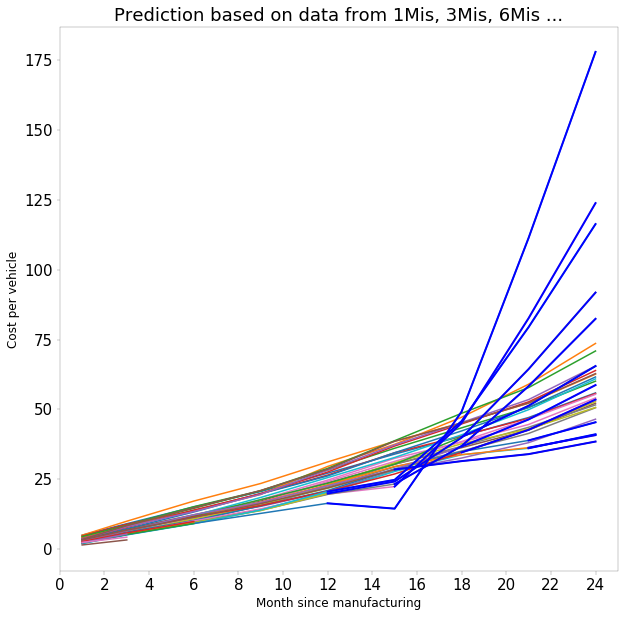

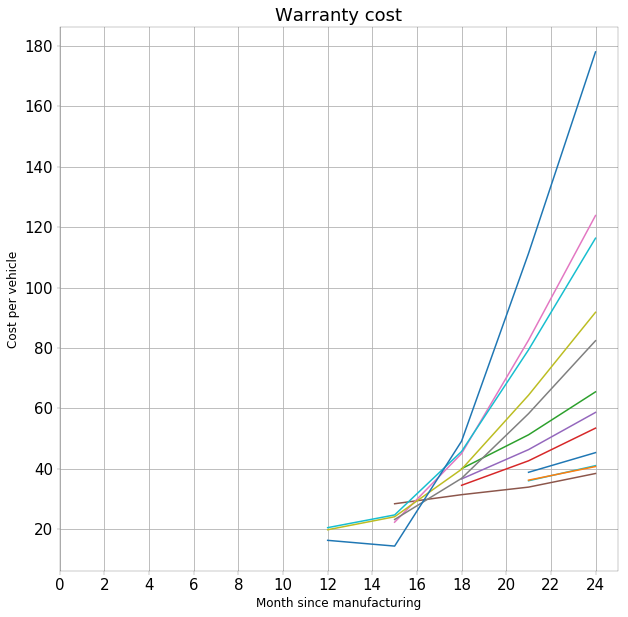

In [413]:
zero_df = pd.DataFrame(np.empty((len(data["DATE"]),len(columns))), index = data["DATE"],columns=columns)
# zero_df = fill_blank(zero_df)
zero_df.values[:]=np.nan

df = read()

dates = df.index
predict_df = df 

#On cherche lambdas, vecteur de 3 entiers
lambdas = np.array([ j for j in range(len(e))])

# print(df)
    
for begin in range(15,43,3): #Changer 1 en 3 
#     begin = int(3*np.floor(begin/3))

    to_process = len(df.loc[dates[0]:dates[0]].values[0]) #Cet entier représente l'index jusqu'où il faut apprendre.
    lambdas = np.array([ j for j in range(len(e))])
#     print("To process ",to_process)
    for j in range(begin,len(dates)-9):

        training_data =  df.loc[:dates[3*np.floor((j)/3)]].T[:to_process+1].T #L'une ou l'autre, soit on apprend sur les valeurs
#         training_data =  df.loc[:dates[j]].T[:to_process+1].T #que l'on vient de prédire ou non. (la premiere est Non)
#         print("Training ",training_data)


        pca_ref = build_pca(training_data, show_porcent = False)
        e=np.array(pca_ref.components_ )#eigenfunctions

        # Ici il faut calculer tous les Nan à cette date donnée. 

        line = df.loc[dates[j+1]:dates[j+1]].values[0]
    #     print(line)
        to_process = np.argwhere(np.isnan(line))[0][0]

        data_to_extend = line[:to_process]


        def to_minimize(lambdas):
            temp = lambdas[0]*e[0][:to_process] + lambdas[1]*e[1][:to_process] + lambdas[2]*e[2][:to_process]
            return np.sum((temp - data_to_extend)**2 )

    #     print(to_minimize(lambdas))

        res = minimize(to_minimize, lambdas)

    #     print("lambdas = ",res.x)
        lambdas = res.x

        test_value = lambdas[0]*e[0][to_process] + lambdas[1]*e[1][to_process] + lambdas[2]*e[2][to_process]

        test_value = round(test_value,1)

        tempo = df.values 
        df.values[j+1,to_process] = test_value 
        zero_df.values[j+1,to_process] = test_value 
#         print(df)

# print(df)    
fig = plot_months(df,title = "Prediction based on data from 1Mis, 3Mis, 6Mis ...",show = False)
add_plot_months(zero_df, fig)

plt.show()


plot_months(zero_df, show = True)
plt.show()

In [411]:
def read_fill():
    data = r.data

    mis = ["1MIS", "3MIS", "6MIS", "9MIS", "12MIS", "15MIS", "18MIS", "21MIS", "24MIS"]

    cout=[]
    columns=[]
    for i in range(len(data)):
        month_cout=[]
        month_data = data.loc[i]

        for m in mis:   
            if(i==0):
                if(len(m)==4):
                    month = int(m[0])
                elif(len(m)==5):
                    month = int(m[0:2])
                columns.append(month)

            month_cout.append(month_data[m])
        cout.append(month_cout)

    cout=np.array(cout)


    df = pd.DataFrame(cout, index = data["DATE"],columns=columns)
    df_fill = fill_blank(df)
    return df_fill

/home/jean-baptiste/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


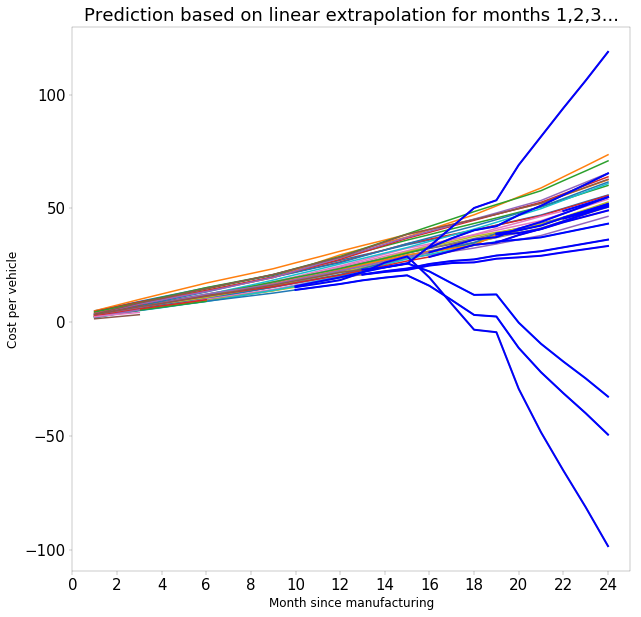

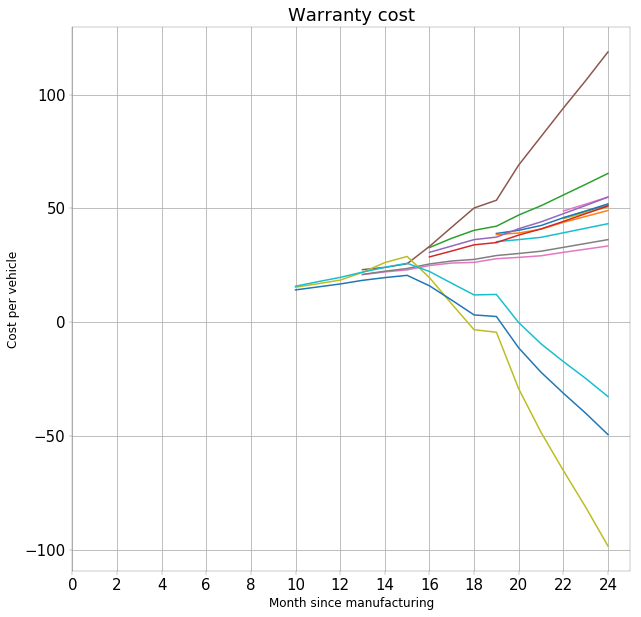

In [414]:
zero_df = pd.DataFrame(np.empty((len(data["DATE"]),len(columns))), index = data["DATE"],columns=columns)
zero_df = fill_blank(zero_df)
zero_df.values[:]=np.nan

df = read_fill()

dates = df.index
predict_df = df 

#On cherche lambdas, vecteur de 3 entiers
lambdas = np.array([ j for j in range(len(e))])

# print(df)
    
for begin in range(15,43,1): #Changer 1 en 3 
    begin = int(3*np.floor(begin/3))

    to_process = len(df.loc[dates[0]:dates[0]].values[0]) #Cet entier représente l'index jusqu'où il faut apprendre.
    lambdas = np.array([ j for j in range(len(e))])
#     print("To process ",to_process)
    for j in range(begin,len(dates)-9):

        training_data =  df.loc[:dates[3*np.floor((j)/3)]].T[:to_process+1].T #L'une ou l'autre, soit on apprend sur les valeurs
#         training_data =  df.loc[:dates[j]].T[:to_process+1].T #que l'on vient de prédire ou non. (la premiere est Non)
#         print("Training ",training_data)


        pca_ref = build_pca(training_data, show_porcent = False)
        e=np.array(pca_ref.components_ )#eigenfunctions

        # Ici il faut calculer tous les Nan à cette date donnée. 

        line = df.loc[dates[j+1]:dates[j+1]].values[0]
    #     print(line)
        to_process = np.argwhere(np.isnan(line))[0][0]

        data_to_extend = line[:to_process]


        def to_minimize(lambdas):
            temp = lambdas[0]*e[0][:to_process] + lambdas[1]*e[1][:to_process] + lambdas[2]*e[2][:to_process]
            return np.sum((temp - data_to_extend)**2 )

    #     print(to_minimize(lambdas))

        res = minimize(to_minimize, lambdas)

    #     print("lambdas = ",res.x)
        lambdas = res.x

        test_value = lambdas[0]*e[0][to_process] + lambdas[1]*e[1][to_process] + lambdas[2]*e[2][to_process]

        test_value = round(test_value,1)

        tempo = df.values 
        df.values[j+1,to_process] = test_value 
        zero_df.values[j+1,to_process] = test_value 
#         print(df)

# print(df)    
fig = plot_months(df,show = False, title = "Prediction based on linear extrapolation for months 1,2,3...")
add_plot_months(zero_df, fig)

plt.show()


plot_months(zero_df, show = True)
plt.show()